# 深度学习入门(day3) - pytorch实现回归模型
## 线性回归的简洁实现
使用pytroch简洁的实现线性回归模型
### 生成数据集
首先生成人工数据集

In [1]:
import numpy as np
import torch
from torch.utils import data

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = torch.tensor(4.2)

features, labels = synthetic_data(true_w, true_b, 1000)

### 读取数据集
调用`torch.utils`模块中的`DataLoader`方法读取数据集，它可以通过设定`shuffle`自动打乱顺序，同时返回批量为`batch_size`的可迭代对象。

In [2]:
def load_array(data_array, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_array) # 传入的data_array是元组(X, y)，要先解包，它能将多个tensor对齐组成数据集。
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.2391,  0.5222],
         [ 0.6032, -0.7112],
         [-0.3235, -0.7194],
         [-0.8582,  0.7941],
         [-0.3545,  0.7127],
         [-0.1352, -2.4194],
         [ 0.8341,  0.3817],
         [-0.4976,  0.1100],
         [ 0.1163, -1.0321],
         [ 1.5996, -0.9930]]),
 tensor([[ 4.9098],
         [ 7.8291],
         [ 5.9892],
         [-0.2285],
         [ 1.0782],
         [12.1557],
         [ 4.5773],
         [ 2.8291],
         [ 7.9469],
         [10.7816]])]

### 定义模型
首先定义一个模型变量`net`，它是一个`Sequential`类的实例。当给定输入数据时，它能将数据传入第一层，然后将第一次层的输出作为第二层的输入。。。

In [3]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) # Linear方法接受两个参数，第一个参数指定输入特征的形状，第二个指定输出特征的形状。

### 初始化模型参数
可以通过`net[0]`来选定第一个层，使用`weight.data`和`bias.data`访问参数，它会被初始化成随机值，可以使用`normal_`和`fill_`来重写参数。

In [4]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数
pytorch中的均方损失是`MSELoss`类，它默认返回所有样本损失的平均值（由reduction指定mean、sum、none）。

In [5]:
loss = nn.MSELoss()

### 定义优化算法
在pytorch的`optim`模块中有很多梯度下降算法的变种，这里使用`SGD`，它接收的`params`参数通过`net.parameters()`获得

In [6]:
trainer =torch.optim.SGD(net.parameters(), lr=0.03)

#### 训练
对于每一个迭代周期里，通过迭代器不停的获取小批量的输入和相应的标签，对每一个小批量数据执行:

1. 通过调用net(X)生成预测并计算损失l（前向传播）。

2. 通过进行反向传播来计算梯度。

3. 通过调用优化器来更新模型参数。

In [7]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        trainer.zero_grad() # 清空梯度
        l.backward()
        trainer.step() # 执行一步梯度下降，更新参数。
    l = loss(net(features), labels) # 观察每一个迭代周期的训练效果
    print(f'epoch {epoch+1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000299
epoch 2, loss 0.000102
epoch 3, loss 0.000101
w的估计误差： tensor([-8.7142e-04, -3.1710e-05])
b的估计误差： tensor([0.0005])


## softmax回归的简洁实现
通过深度学习框架的高级API也能更方便地实现softmax回归模型。

In [8]:
import torch
from torch import nn
import torchvision
from torchvision import transforms


def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 初始化模型参数
softmax回归的输出层是一个全连接层。因此，只需在Sequential中添加一个带有10个输出的全连接层。

In [9]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# 通常第 0 维是批大小（batch_size），默认跳过，从第 1 维开始展平。
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### softmax的实现
对于之前的softmax函数 $\hat{y_i}=\frac{e^{o_j}}{\sum_{k}{e^{o_k}}}$，如果 $o_k$ 中的一些数值非常大，那么 $e^{o_k}$ 可能会大过数据类型的上限，即上溢。可能会使分母变成inf，导致结果为0、inf或nan的 $\hat{y_j}$。

解决技巧是：先从所有 $o_k$ 中减去 $\max{(o_k)}$。

$$
\begin{aligned}
\hat{y_i} &= \frac{e^{o_j-\max{(o_k)}}e^{\max{(o_k)}}}{\sum_{k}e^{o_k-\max{(o_k)}}e^{\max{(o_k)}}} \\
&= \frac{e^{o_j-\max{(o_k)}}}{\sum_{k}e^{o_k-\max{(o_k)}}}
\end{aligned}
$$

经过以上步骤，可能有一些 $o_j - \max{(o_k)}$ 具有较大的负值。由于精度受限，$e^{o_j - \max{(o_k)}}$ 将会有接近零的值，即下溢。这些值可能会四舍五入为零，使 $\hat{y_i}$ 的值为 $-\infty$。

将softmax和交叉熵结合在一起，可以避免计算指数函数：
$$
\begin{aligned}
\log{(\hat{y_i})} &= \log{\left( \frac{e^{o_j-\max{(o_k)}}}{\sum_{k}e^{o_k-\max{(o_k)}}} \right)} \\
&= \log{(e^{(o_j - \max{(o_k)})})} - \log{\left( \sum_{k}e^{o_k-\max{(o_k)}} \right)} \\
&= o_j - \max{(o_k)} - \log{\left( \sum_{k}e^{o_k-\max{(o_k)}} \right)}
\end{aligned}
$$

最后在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数

In [10]:
"""自动对模型的原始输出（logits，未归一化的分数）进行 LogSoftmax 处理，无需手动添加 Softmax 层。"""
loss = nn.CrossEntropyLoss(reduction='none') 

### 优化算法
使用学习率为0.1的小批量随机梯度下降作为优化算法。

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 训练
先定义绘图工具类

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 在 Jupyter 中设置矢量图显示
import matplotlib.pyplot as plt
from IPython import display

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat 为矩阵
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


# 先定义一个累加器工具
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n # 定义长度为n的列表
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # 列表与输入值累加

    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx] # 重写[]方法


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        
        # 创建图形和坐标轴
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]  # 统一为列表格式方便后续操作
            
        # 坐标轴配置函数（原生替代d2l.set_axes）
        def config_axes(ax):
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if xlim: ax.set_xlim(xlim)
            if ylim: ax.set_ylim(ylim)
            ax.set_xscale(xscale)
            ax.set_yscale(yscale)
            if legend: ax.legend(legend)
            ax.grid()
            
        self.config_axes = lambda: config_axes(self.axes[0])  # 绑定配置函数
        
        # 初始化数据容器
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 处理单值输入（兼容标量输入）
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        
        # 处理x输入（兼容标量输入）
        if not hasattr(x, "__len__"):
            x = [x] * n  # 所有y序列共享相同x值
            
        # 初始化数据存储列表
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
            
        # 添加数据点
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        # 清除当前图形并重绘
        self.axes[0].cla()
        for x_data, y_data, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x_data, y_data, fmt)
            
        # 配置坐标轴
        self.config_axes()
        
        # 动态显示图形（需在Jupyter中运行）
        display.display(self.fig)
        display.clear_output(wait=True)

再定义训练函数

In [13]:
def train_epoch(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

开始训练

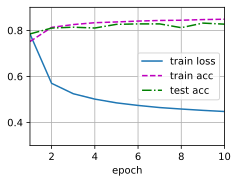

In [14]:
num_epoch = 10
train(net, train_iter, test_iter, loss, num_epoch, trainer)

## 总结
使用深度学习框架的内置API，不仅可以简洁高效的训练模型，还额外采取预防措施避免数值异常。